In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
import os
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from IPython.display import display
%matplotlib inline

EPSILON = 1e-7

warnings.filterwarnings("ignore")

In [2]:
def gaussian2d(shape=(5,5),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [3]:
def img_normalization(im_input, m0 = 0.0, var0 = 1.0):
    m = np.mean(im_input.numpy())
    var = np.var(im_input.numpy())
    im_input = im_input.apply_(lambda x: (m0 + (np.sqrt((var0*(x-m)*(x-m))/var))) if (x>m) else (m0-(np.sqrt((var0*(x-m)*(x-m))/var))))
    return im_input     

In [4]:
im = Image.open('./keras_ver/datasets/NIST14/F0000001.bmp')
im = torch.tensor(np.array(im),dtype=torch.float)
#plt.title('Original')
#plt.imshow(np.transpose(im.numpy()),cmap='gray')
#print("Shape:",im.shape)

In [5]:
#Code to export a tensor
#image = torch.Tensor(image)
#torch.save(image,'align.pt')

In [248]:
input_origin = torch.load('./variables/input_origin.pt') #input
print('Input:',input_origin.shape)
output_origin = torch.load('./variables/output_origin.pt') #expected output
print('Output:',output_origin.shape)
Gxx_origin = torch.load('./variables/Gxx_origin.pt')
print('Gxx:',Gxx_origin.shape)
Ix2_origin = torch.load('./variables/Ix2.pt')
print('Ix2:',Ix2_origin.shape)

Input: torch.Size([1, 768, 800, 1])
Output: torch.Size([1, 96, 100, 1])
Gxx: torch.Size([1, 96, 100, 1])
Ix2: torch.Size([1, 768, 800, 1])


In [217]:
def GetPadConfig(input_size, pad_mode, pad_left, pad_right, kernel, stride):
    """Calculates the padding config.
    Inputs:
        input_size (int): the input image size.
        pad_mode (string): either 'SAME', or 'EXPLICIT'
        pad_left, pad_right (int): the padding values used in 'EXPLICIT' mode. Does not have effect in 'SAME'.
        kernel: the kernel size.
        stride: the stride size.
    Returns:
        output_size (int): the output image size.
        pad_left, pad_right (int): the padding values on the left and right.
    """
    if (pad_mode == 'SAME'):
        output_size = int(math.ceil(float(input_size) / float(stride)))
        pad_total = int((output_size - 1) * stride + kernel - input_size)
        pad_left = int(pad_total / 2)
        pad_right = pad_total - pad_left
    elif (pad_mode == 'EXPLICIT'):
        output_size = int((input_size + pad_left + pad_right - kernel) / stride) + 1
    else:
        raise RuntimeError('Wrong pad mode.')
    return pad_left, pad_right

In [255]:
def orientation(image, stride = 8, window = 17):
    assert image.shape[3] == 1, 'Images must be grayscale'
    #(a,b,c,d) -> (a,d,b,c)
    image = image.view(1,1,image.shape[1],image.shape[2])
    strides = stride
    E = torch.Tensor(np.ones([1,1,window,window]))
    sobelx = torch.FloatTensor(np.reshape(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float), [1,1,3,3]))
    sobely = torch.FloatTensor(np.reshape(np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float), [1,1,3,3]))
    gaussian_mask = torch.FloatTensor(np.reshape(gaussian2d((5,5),1),[1,1,5,5]))
    #sobel_gradient
    Ix = torch.nn.functional.conv2d(image,sobelx,stride = 1, padding = 'same')#sobel_x
    Iy = torch.nn.functional.conv2d(image,sobely,stride = 1, padding = 'same')#sobel_y 
    #eltwise_1
    Ix2 = torch.mul(Ix[0,0,:,:],Ix[0,0,:,:])#IxIx
    Ix2 = Ix2.view(1,1,Ix2.shape[0],Ix2.shape[1])
    
    Iy2 = torch.mul(Iy[0,0,:,:],Iy[0,0,:,:])#IyIy
    Iy2 = Iy2.view(1,1,Iy2.shape[0],Iy2.shape[1])
    
    Ixy = torch.mul(Ix[0,0,:,:],Iy[0,0,:,:])#IxIy
    Ixy = Ixy.view(1,1,Ixy.shape[0],Ixy.shape[1])
    
    #Padding for range_sum convolution
    P = 8//2 + 1
    #range_sum
    Gxx = torch.nn.functional.conv2d(Ix2,E,stride = strides,padding = (P,P))#Gxx_sum  
    return Gxx
    Gyy = torch.nn.functional.conv2d(Iy2,E,stride = strides,padding = (P,P))#Gyy_sum
    Gxy = torch.nn.functional.conv2d(Ixy,E,stride = strides,padding = (P,P))#Gxy_sum
    return Gxx
    #eltwise_2
    Gxx_Gyy = torch.sub(Gxx,Gyy)#Gxx_Gyy
    theta = torch.atan2((2*Gxy),Gxx_Gyy) + np.pi
    #gaussian_filter
    phi_x = torch.nn.functional.conv2d((np.cos(theta)), gaussian_mask,stride = 1,padding='same')#gaussian_x
    phi_y = torch.nn.functional.conv2d((np.cos(theta)), gaussian_mask,stride = 1,padding='same')#gaussian_y
    theta = torch.atan2(phi_x,phi_y)/2
    return theta

In [256]:
Gxx_new = orientation(input_origin)

In [257]:
def evaluate_diff(inp,out):
    out = out.view(1,1,out.shape[1],out.shape[2])
    print('received variable shape: ',np.array(inp.shape))
    print("expected output shape: ",np.array(out.shape))
    print("Max value in original is",torch.max(out).numpy(),"and min value is",torch.min(out).numpy())
    print("The max difference is: ",torch.max(torch.sub(inp,out)).numpy())
    print("The mean difference is: ",np.abs(torch.mean(torch.sub(inp,out)).numpy()))
    print("The standard deviation is: ",torch.std(torch.sub(inp,out)).numpy())
    plt.plot(torch.sub(inp,out).view(out.shape[2],out.shape[3]).numpy())
    return

received variable shape:  [  1   1  96 100]
expected output shape:  [  1   1  96 100]
Max value in original is 348.937 and min value is 0.0
The max difference is:  42.813812
The mean difference is:  0.01713115
The standard deviation is:  4.402294


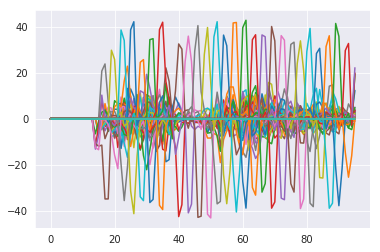

In [258]:
evaluate_diff(Gxx_new,Gxx_origin)

In [268]:
inp = Gxx_new
out = Gxx_origin.view(1,1,Gxx_origin.shape[1],Gxx_origin.shape[2])
dif_map = torch.sub(inp,out).view(inp.shape[2],inp.shape[3]).numpy()

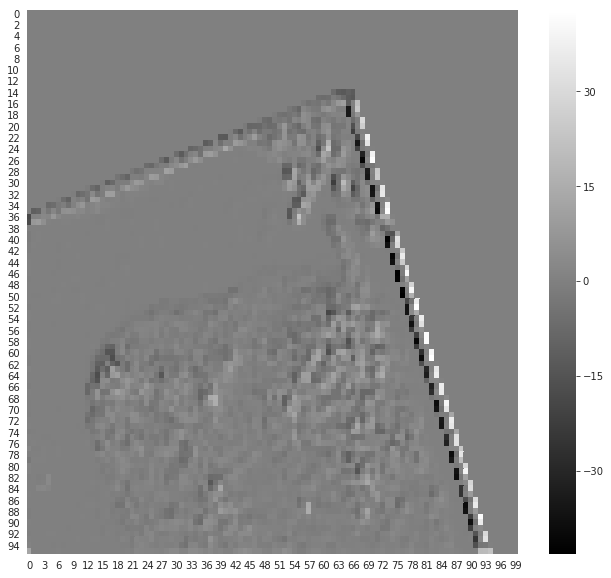

In [269]:
plt.figure(figsize=(11,10))
sns.heatmap(dif_map,cmap='gray')

In [263]:
input_origin.shape

torch.Size([1, 768, 800, 1])

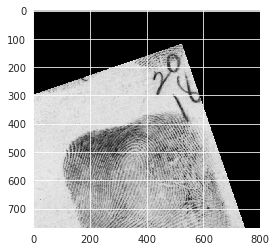

In [265]:
plt.imshow(input_origin.view(input_origin.shape[1],input_origin.shape[2]),cmap='gray')
